In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGeneratori
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

C:\Users\Adil Qureshi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Adil Qureshi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Adil Qureshi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Adil Qureshi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.

In [3]:
# Organize data into train, valid, test dirs
os.chdir('dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [6]:
train_path = 'Adil Qureshi/dogs-vs-cats/train/'
valid_path = 'Adil Qureshi/dogs-vs-cats/valid/'
test_path = 'Adil Qureshi/dogs-vs-cats/test/'

In [7]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = train_path, target_size = (244, 244), classes = ['cat', 'dog'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = valid_path, target_size = (244, 244), classes = ['cat', 'dog'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = test_path, target_size = (244, 244), classes = ['cat', 'dog'], batch_size = 10, shuffle = False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [9]:
imgs, labels = next(train_batches)

In [10]:
# function to plot images in a 1 by 10 grid taken directly from Tensor Flow's website. url: https://www.tensorflow.org/tutorials/images/classification#visualize_training_images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

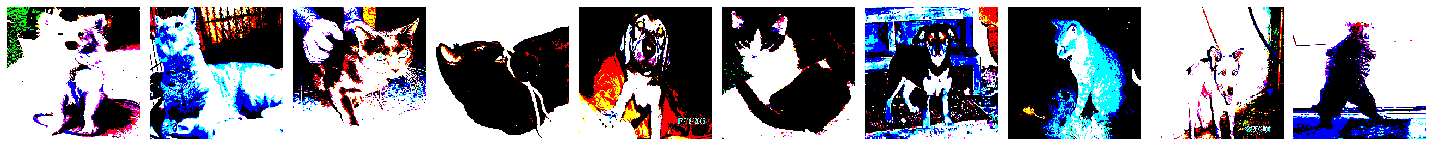

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [11]:
plotImages(imgs) 
print(labels) # [0. 1.] for dog, [1. 0.] for cat

In [12]:
model = Sequential([
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (244,244,3)),
        MaxPool2D(pool_size = (2,2), strides = 2),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Flatten(),
        Dense(units = 2, activation = 'softmax')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 244, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
flatten (Flatten)            (None, 952576)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1905154   
Total params: 1,924,546
Trainable params: 1,924,546
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

In [15]:
model.fit(x = train_batches, validation_data = valid_batches, epochs = 10, verbose = 2)

Epoch 1/10
100/100 - 47s - loss: 55.6035 - acc: 0.5910 - val_loss: 27.6153 - val_acc: 0.6100
Epoch 2/10
100/100 - 46s - loss: 5.7664 - acc: 0.7870 - val_loss: 9.0212 - val_acc: 0.6400
Epoch 3/10
100/100 - 44s - loss: 0.9505 - acc: 0.9170 - val_loss: 6.0976 - val_acc: 0.6200
Epoch 4/10
100/100 - 45s - loss: 0.2795 - acc: 0.9550 - val_loss: 5.8092 - val_acc: 0.6200
Epoch 5/10
100/100 - 44s - loss: 0.0907 - acc: 0.9820 - val_loss: 7.1361 - val_acc: 0.6050
Epoch 6/10
100/100 - 47s - loss: 0.0791 - acc: 0.9880 - val_loss: 5.5666 - val_acc: 0.6600
Epoch 7/10
100/100 - 47s - loss: 0.0053 - acc: 0.9980 - val_loss: 5.2767 - val_acc: 0.6200
Epoch 8/10
100/100 - 47s - loss: 0.0081 - acc: 0.9970 - val_loss: 5.3018 - val_acc: 0.6250
Epoch 9/10
100/100 - 46s - loss: 7.4579e-04 - acc: 1.0000 - val_loss: 5.4145 - val_acc: 0.6300
Epoch 10/10
100/100 - 45s - loss: 2.9091e-05 - acc: 1.0000 - val_loss: 5.4116 - val_acc: 0.6250
